### Text Translation 

Seq2seq LSTM encoder-decoder with attention

Jay Urbain, PhD

Acknowledgement: code based on keras-visualize-activations of Philippe Remy

URL: https://github.com/philipperemy/keras-visualize-activations

The idea of date translation is borrowed from https://github.com/datalogue/keras-attention.

For the real case we have used https://github.com/NVIDIA/OpenSeq2Seq, NVIDIA's implementation of Seq2Seq model.

Introductory resources for using `attention`:  
http://www.wildml.com/2016/01/attention-and-memory-in-deep-learning-and-nlp/

#### Text Translation using seq2seq encoder-decoder with attention

**Let's suppose we are tasked with translating from some language into English.** 

Below are 5 different results from different translation models. While we don't know what the original sentence might be, we can see that the context can be easily figured out from the following examples when considered as a group. 

Translation A: I ask him whether he will once again make a stand-up comedy tour.

Translation B: I ask him if he will again make a stand-up comedy tour.

Translation C: I wonder him if he will ever make a booth up comedy tour.

Translation D: I ask him if he will ever make a stand-up comedy tour ever.

Translation E: I ask him whether he will again make a stand-up comedy tour.

#### TODO:

Rank the translations from Best to Worst

Rank: Fill-in






It should be relatively easy to spot poor translations since they don't quite make sense when translated into English. 

We are going to skip the code below which uses the nVidia OpenSeq2Seq library to generate translations from [baseline.txt](baseline.txt). The models were too large to include within the Docker file. However, I ran it and included a few samples in the following cell.

In [8]:
#!python OpenSeq2Seq/run.py --config_file=OpenSeq2Seq/example_configs/nmt.json --logdir=./noatt --mode=infer --inference_out=baseline.txt

After running ~3.5 minutes (on a GPU) you'll see translations like "I wonder him if he will ever make a booth up com@@ ed@@ y@@ tour ." A good place to stop.

The "com@@" is due to <a href='https://en.wikipedia.org/wiki/Byte_pair_encoding'>byte pair encoding (BPE)</a>. You can simply eliminate those characters for now.

This shows the difficulty of translating in general. Notice how small phrases or word groups are easier to translate. E.g., "stand-up comedy tour." But larger contextual depencies are problematic. We hope to solve this problem by using attention in our models. 


In [9]:
from keras.layers import Embedding, Bidirectional
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.layers.merge import Multiply
from keras.utils import to_categorical
from keras.layers import TimeDistributed
from keras.backend import int_shape

import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### 1 - Translating human readable dates into machine readable dates

Neural Machine Translation (NMT) is typically used to translate sentences from a source language (e.g. Arabic) to a target language (e.g. Hindi), however NMT has a wide range of applications. 

In this notebook, you're going to build an NMT model to translate human readable dates (e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987") into machine readable dates (e.g. "1958-08-29", "1968-03-30", "1987-06-24"). We'll be standardizing the dates on the US date encoding of MM/dd/YYYY when generating the dates. The machine readable format is in YYYY-MM-dd format. 

You can review [nmt_utils.py](nmt_utils.py) to see the date formatting. Try to figure out how the formats work. This knowledge may help later.

#### 1.1 - Dataset

The dataset is a corpus of `1000` human readable dates and their equivalent machine readable dates. Run the following cell to load the dataset and print some information.

In [10]:
m = 1000
dataset, human_vocab, machine_vocab, inv_machine_vocab = create_dataset(m)

Tx = 20
# The single star * unpacks the sequence/collection into positional arguments
sources, targets = zip(*dataset)
sources = np.array([string_to_int(i, Tx, human_vocab) for i in sources])
targets = [string_to_int(t, Tx, machine_vocab) for t in targets]
targets = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), targets)))

100%|██████████| 1000/1000 [00:00<00:00, 23035.75it/s]


What we've loaded:
- dataset: a list of tuples (human readable date, machine readable date)
- human_vocab: a python dictionary mapping all characters used in human readable dates to an index (integer values)
- machine_vocab: a python dictionary mapping all characters used in machine readable dates to an index (integer values)
- inv_machine_vocab: the inverse dictionary of `machine_vocab`
- sources: a processed version of dataset's human readable dates, where each character is replaced by the integer value it is mapped to in the human_vocab, padded to $T_x$ values. `sources.shape = (m, Tx)`
- targets: a processed version of dataset's machine readable dates, where each character is replaced by the one-hot vector of the character it is mapped to in the machine_vocab, the date is also padded up to $T_x$. `targets.shape = (m, Tx, len(machine_vocab))`

Play with the index in the cell below to navigate in the dataset, and see how source/target dates are preprocessed. The source uses an index, the target uses one-hot encoding.

In [11]:
index = 12
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing:", sources[index])
print("Target after preprocessing:", targets[index])

Source date: 21, JUL 2008
Target date: 2008-07-21

Source after preprocessing: [27 16 43  3 18 47  7  3 27 25 25  5 59 59 59 59 59 59 59 59]
Target after preprocessing: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

### 1.2 - Model architecture

Your NMT model will use an encoder-decoder architecture. One training example's run through the model is explained in the figures below.

<img src="images/enc.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 1**: Simple NMT model (encoder part) </center></caption>

First, a preprocessed source date is encoded using a Bi-directional LSTM. The sequence of hidden states are returned and stored in an object called `enc_out`. `enc_out` is then given as an input sequence to the decoder, which is described in the figure below.

<img src="images/dec.png" style="width:500;height:300px;"> <br>
<caption><center> **Figure 2**: Simple NMT model (decoder part) </center></caption>

The output vectors can then be compared to the ground truth using a categorical cross-entropy loss function. Minimizing this loss function will give you a trained NMT model. 

**TODO**:   
Review the following code.

Implement the `model_simple_nmt()` described in the figure above. The LSTMs both use 32 units. The embedding layer outputs a 64-dimensional embedding and should be trainable. These functions might be useful: Input(), [Embedding()](https://keras.io/layers/embeddings/), [LSTM()](https://keras.io/layers/recurrent/#lstm), [Bidirectional()](), [Dense()](https://keras.io/layers/core/#dense), [TimeDistributed()](https://keras.io/layers/wrappers/#timedistributed), [Model()](https://keras.io/models/model/).



In [12]:
def model_simple_nmt(human_vocab_size, machine_vocab_size, Tx = 20):
    """
    Simple Neural Machine Translation model
    
    Arguments:
    human_vocab_size -- size of the human vocabulary for dates, it will give us the size of the embedding layer
    machine_vocab_size -- size of the machine vocabulary for dates, it will give us the size of the output vector
    
    Returns:
    model -- model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define the input of your model with a shape (Tx,)
    inputs = Input(shape=(Tx,))
    
    # Define the embedding layer. This layer should be trainable and the input_length should be set to Tx.
    input_embed = Embedding(human_vocab_size, 2*32, input_length = Tx, trainable=True)(inputs)
    
    # Encode the embeddings using a bidirectional LSTM
    enc_out = Bidirectional(LSTM(32, return_sequences=True))(input_embed)
    
    # Decode the encoding using an LSTM layer
    dec_out = LSTM(32, return_sequences=True)(enc_out)
    
    # Apply Dense layer to every time steps
    output = TimeDistributed(Dense(machine_vocab_size, activation='softmax'))(dec_out)
    
    # Create model instance 
    model = Model(input=[inputs], output=output)
    
    ### END CODE HERE ###
    
    return model

Run the following cell to create your `model` and compile it.

In [14]:
# Create model
model = model_simple_nmt(len(human_vocab), len(machine_vocab), Tx)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/Users/jayurbain/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ti...)`


Let's train this model for 200 epochs by changing and running the following cell:

In [15]:
### START CODE HERE ###
model.fit([sources], targets, epochs=10, batch_size=512, validation_split=0.1)
### END CODE HERE ###

Train on 900 samples, validate on 100 samples
Epoch 1/10
900/900 [==============================] - 2s 2ms/step - loss: 2.5664 - acc: 0.0533 - val_loss: 2.5521 - val_acc: 0.4260
Epoch 2/10
900/900 [==============================] - 0s 139us/step - loss: 2.5479 - acc: 0.4608 - val_loss: 2.5308 - val_acc: 0.5000
Epoch 3/10
900/900 [==============================] - 0s 137us/step - loss: 2.5260 - acc: 0.5000 - val_loss: 2.5051 - val_acc: 0.5000
Epoch 4/10
900/900 [==============================] - 0s 139us/step - loss: 2.4991 - acc: 0.5000 - val_loss: 2.4721 - val_acc: 0.5000
Epoch 5/10
900/900 [==============================] - 0s 147us/step - loss: 2.4643 - acc: 0.5000 - val_loss: 2.4271 - val_acc: 0.5000
Epoch 6/10
900/900 [==============================] - 0s 139us/step - loss: 2.4163 - acc: 0.5000 - val_loss: 2.3648 - val_acc: 0.5000
Epoch 7/10
900/900 [==============================] - 0s 140us/step - loss: 2.3497 - acc: 0.5000 - val_loss: 2.2774 - val_acc: 0.5000
Epoch 8/10
900/900

#### 1.4 - Results

Try your simple NMT model on various examples using the code below:

In [16]:
# this is where you adjust examples
EXAMPLES = ['3 May 1979', '5 Apr 09', '20th February 2016', 'Wed 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '3rd of March 2001']

def run_examples(examples):
    for example in examples:
        source = string_to_int(example, Tx, human_vocab)
        prediction = model.predict(np.array([source]))
        prediction = np.argmax(prediction[0], axis = -1)
        output = int_to_string(prediction, inv_machine_vocab)
        print("source:", example)
        print("output:", ''.join(output))
    
run_examples(EXAMPLES)

source: 3 May 1979
output: <pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
source: 5 Apr 09
output: <pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
source: 20th February 2016
output: <pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
source: Wed 10 Jul 2007
output: <pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
source: Saturday May 9 2018
output: <pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
source: March 3 2001
output: <pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
source: March 3rd 2001
output: <pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
source: 3rd of March 2001
output: <pad><pad><pad><pad><pad><pad><pad><pad><pad

source: 3 May 1979 <br>
output: 1979-05-03

source: 5 Apr 09 <br>
output: 2009-04-05

source: 20th February 2016 <br>
output: 2016-09-20

source: Wed 10 Jul 2007 <br>
output: 2007-04-10

source: Saturday May 9 2018 <br>
output: 2018-05-28

source: March 3 2001 <br>
output: 2001-03-03

source: March 3rd 2001 <br>
output: 2000-03-03

source: 3rd of March 2001 <br>
output: 2000-12-03

It does relatively well as the first two examples show.

We can intuit that the longer the string, and the more items to retain while doing the translation, the bigger the errors tend to be. Even for us, when we want to improve our results, we have to pay *attention* to the task we are currently doing. So intuitively, if we provide Neural Networks the ability to give more attention to relevant sections and also retain information over the long inputs, then results should improve. To that end, you are going to add an attention mechanism to your NMT and see if it improves the results or not.

#### TODO:

Now it's your turn to create your test set and produce similar output. Remember all the data formats that we asked you to investigate? Now create 5 formats that do not appear in EXAMPLES (code cell above) that we have given for your test set below. Then complete the code so prediction is run on all of them and you output a similar output string as we have shown:

### 2 - Improving results using attention

If you had to translate a book's paragraph from French to English, you would not read the whole paragraph, then close the book and translate. You would first read the paragraph. Then, while translating, you would read and focus on the parts of the paragraph corresponding to the parts you are currently translating.

Attention mechanism is a technique in Deep Learning to help the model drive its focus onto important parts of the input. In this part, you will augment your simple NMT with attention. 

#### 2.1 - Attention models

<img src="images/NMT_Components.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 3**: Attention NMT model</center></caption>

Concretely, after running a source date in the encoder (Bi-LSTM), you would like to give all the hidden states to the decoder to get back the target date. However, at every step in the decoding process, you'd like your model to be able to tell which hidden state is more important to use. So, inserting the attention block between encoder and decoder is the new architecture we will use to decipher the important parts of the input to pay attention to. 

<img src="images/Attention_mechanism.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 4**: Attention Implementation</center></caption>

The above figure contains enlarged details of the attention block itself. The attention block takes the outputs from the encoder, and applies different weights to them with tanh as the activation function. Softmax will choose the winning vector and apply attention to that output from the encoder. There are various ways and methods of implementing an attention mechanism, but the basic principle is the same. It will choose the most relevant part of the input to focus the attention and retain knowledge over long inputs in order to provide a better translation.

Now, let's implement a simplified attention block using softmax and dimension reduction on vectors:

In [17]:
def attention_3d_block(inputs):
    """
    Implement the attention block applied between two layers
    
    Argument:
    inputs -- output of the previous layer, set of hidden states
    
    Returns:
    output_attention_mul -- inputs weighted with attention probabilities
    """
    
    # Retrieve n_h and Tx from inputs' shape. Recall: inputs.shape = (m, Tx, n_h)
    Tx = int_shape(inputs)[1]
    n_h = int_shape(inputs)[2]
    
    ### START CODE HERE ###
    # Permute inputs' columns to compute "a" of shape (m, n_h, Tx)
    a = Permute((2, 1))(inputs)
    
    # Apply a Dense layer with softmax activation. It should contain Tx neurons. a.shape should still be (m, n_h, Tx).
    a = Dense(Tx, activation='softmax')(a)
    
    # Compute the mean of "a" over axis=1 (the "hidden" axis: n_h). a.shape should now be (m, Tx)
    a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
    
    # Repeat the vector "a" n_h times. "a" should now be of shape (m, n_h, Tx)
    a = RepeatVector(n_h)(a)
    
    # Permute the 2nd and the first column of a to get a probability vector of attention. a_probs.shape = (m, Tx, n_h)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    
    # Apply the attention probabilities to the "inputs" by multiplying element-wise.
    output_attention_mul = Multiply(name='attention_mul')([inputs, a_probs])
    ### END CODE HERE ###
    
    return output_attention_mul

#### 2.2 - Assessing the efficiency of this attention block

In order to ensure that the activation block you have just coded is able to tell the model where to focus, you are going to try an experiment.

Let's first generate datapoints $(X, Y) = $ {$(x^{(i)}, y^{(i)})_{i=1...m}$} such that:
- $y^{(i)}$ is a label equal to 0 or 1.
- $x^{(i)}$ is a matrix of shape $(T_x, n_h)$ where one column is equal to $y^{(i)}$  and the rest is random. It means that for some time-step "t", we have x[t,:] = y.
- Thus `X.shape =` $(m, T_x, n_h)$ and `Y.shape =` $(m, 1)$.

Lets generate some fake data with actual answers in one of the dimensions. If our attention model is working, it will point out the column with answers.

In [18]:
def get_data_recurrent(n, time_steps, input_dim, attention_column=None):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    if attention_column is None:
        attention_column = np.random.randint(low=0, high=input_dim)
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    return x, y

Run the cell below to see some examples of X and Y.

In [19]:
np.random.seed(1)
x, y = get_data_recurrent(n = 2, time_steps = 4, input_dim = 3, attention_column=None)
print("x.shape =", x.shape)
print("x =", x)
print()
print("y.shape =", y.shape)
print("y =", y)

x.shape = (2, 4, 3)
x = [[[-0.54974618 -1.40287272  1.5827523 ]
  [ 1.          1.          1.        ]
  [-1.50780766 -0.31529207  0.85817886]
  [ 0.07134299 -2.29230928 -1.41555249]]

 [[ 0.8858294   0.63190187  0.04026035]
  [ 1.          1.          1.        ]
  [-0.53524902  0.77735121  0.17133845]
  [-0.44285144  1.70490377  0.92434585]]]

y.shape = (2, 1)
y = [[1]
 [1]]


The dataset (X, Y) is useful to observe the impact of attention. Indeed, you will try a binary classifier that given x will predict y. Thanks to the attention mechanism, your network should understand that only one time-step of x is useful to predict y, the rest is random. Your model should focus solely on this particular time-step. Run the following cell to load the dataset with attention on the third time-step.

In [20]:
X, Y = get_data_recurrent(n = 10000, time_steps = 20, input_dim = 2, attention_column = 3)

#### 2.2.1 - Attention along with LSTM

The attention block can be mounted at different positions in the network. The most common positions are before and after an LSTM. Below, we are providing two different models with the attention block applied before and after the LSTM.

In [21]:
def model_attention_applied_before_lstm(Tx, n_h):
    """
    Model with attention applied BEFORE the LSTM
        
    Returns:
    model -- Keras model instance
    """
    
    # Define the input of your model with a shape (Tx,)
    inputs = Input(shape=(Tx, n_h,))
    # Add the attention block
    attention_mul = attention_3d_block(inputs)
    # Pass the inputs in a LSTM layer, return the sequence of hidden states
    attention_mul = LSTM(32, return_sequences=False)(attention_mul)
    # Apply Dense layer with sigmoid activation the output should be a single number.
    output = Dense(1, activation='sigmoid')(attention_mul)
    # Create model instance 
    model = Model(input=[inputs], output=output)
    
    return model

In [22]:
def model_attention_applied_after_lstm(Tx, n_x):
    """
    Model with attention applied AFTER the LSTM
    
    Returns:
    model -- Keras model instance
    """
    
    # Define the input of your model with a shape (Tx,)
    inputs = Input(shape=(Tx, n_x,))
    # Pass the inputs in a LSTM layer, return the sequence of hidden states
    lstm_out = LSTM(32, return_sequences=True)(inputs)
    # Add the attention block
    attention_mul = attention_3d_block(lstm_out)
    # Flatten the output of the attention block
    attention_mul = Flatten()(attention_mul)
    # Apply Dense layer with sigmoid activation the output should be a single number.
    output = Dense(1, activation='sigmoid')(attention_mul)
    # Create model instance 
    model = Model(input=[inputs], output=output)
    
    return model

You will train the model with attention applied after the LSTM. Later on, you can come back and try the model with attention applied before the LSTM. One advantage of applying attention before the LSTM on the inputs directly is that, it is easier to reason about. The probability distribution spans across the input dimensions only. Whereas, applying to the output of the LSTM makes the dimensional space much more complex to interpret and reason about but more commonly used.  

In [23]:
m = model_attention_applied_after_lstm(Tx = 20, n_x = 2)

/Users/jayurbain/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Run the cell below to compile the model you've just created.

In [24]:
m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### TODO:

Running the cell below will train your model over the (X, Y) dataset for 100 epochs and a batch size of 512.

In [25]:
### START CODE HERE ###
m.fit([X], Y, epochs=10, batch_size=16, validation_split=0.1)
### END CODE HERE ###

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 10s 1ms/step - loss: 0.4987 - acc: 0.7531 - val_loss: 0.0616 - val_acc: 1.0000
Epoch 2/10
9000/9000 [==============================] - 9s 1ms/step - loss: 0.0189 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 3/10
9000/9000 [==============================] - 9s 1ms/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 4/10
9000/9000 [==============================] - 9s 1ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 5/10
9000/9000 [==============================] - 10s 1ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 7.6019e-04 - val_acc: 1.0000
Epoch 6/10
9000/9000 [==============================] - 9s 1ms/step - loss: 6.0809e-04 - acc: 1.0000 - val_loss: 4.6788e-04 - val_acc: 1.0000
Epoch 7/10
9000/9000 [==============================] - 10s 1ms/step - loss: 3.8558e-04 - acc: 1.0000 - val_loss: 3.0439e-04 - val_acc

Now let's define get_activations so we can extract out relevant information from the layers to analyze our results.

In [26]:
def get_activations(model, inputs, layer_name=None):
    """
    For a given Model and inputs, find all the activations in specified layer
    If no layer then use all layers
    
    Returns:
    activations from all the layer(s)
    """
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
    return activations

#### TODO:

Define all the variables and parameters below. This is where you'll modify parameters later in the lab.

In [27]:
### START CODE HERE ###
# Set the input dimensions
INPUT_DIM = 2

# Set time steps
TIME_STEPS = 20

# if True, the attention vector is shared across the input_dimensions where the attention is applied.
# Set whether the attention vector is shared
SINGLE_ATTENTION_VECTOR = False

# Set the attention model in relation to LSTM
APPLY_ATTENTION_BEFORE_LSTM = False

# Set the size of the dataset
N = 300000
### END CODE HERE ###

Once you have determined the parameters you want to experiment with. Run the following cell and let the model compile.

In [28]:
inputs_1, outputs = get_data_recurrent(N, TIME_STEPS, INPUT_DIM, attention_column=3)

if APPLY_ATTENTION_BEFORE_LSTM:
    m = model_attention_applied_after_lstm(Tx = 20, n_x = 2)
else:
    m = model_attention_applied_before_lstm(Tx = 20, n_h = 2)

m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(m.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 20, 2)        0                                            
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 2, 20)        0           input_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 2, 20)        420         permute_2[0][0]                  
__________________________________________________________________________________________________
dim_reduction (Lambda)          (None, 20)           0           dense_5[0][0]                    
__________________________________________________________________________________________________
repeat_vec

/Users/jayurbain/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


To see if your model and parameters worked, let's generate 300 training examples with `attention_column=3` by calling get_activations on it. 

In [29]:
m.fit([inputs_1], outputs, epochs=1, batch_size=512, validation_split=0.1)

attention_vectors = []
for i in range(300):
    # Generate one training example (x, y), the attention column can be on any time-step.
    testing_inputs_1, testing_outputs = get_data_recurrent(1, TIME_STEPS, INPUT_DIM, attention_column=3)
    # Extract the attention vector predicted by the model "m" on the training example "x".
    attention_vector = np.mean(get_activations(m,
                                               testing_inputs_1,
                                               layer_name='attention_vec')[0], axis=2).squeeze()
    # Append the attention vector to the list of attention vectors
    assert (np.sum(attention_vector) - 1.0) < 1e-5
    attention_vectors.append(attention_vector)
# Compute the average attention on every time-step

attention_vector_final = np.mean(np.array(attention_vectors), axis=0)

Train on 270000 samples, validate on 30000 samples
Epoch 1/1
270000/270000 [==============================] - 11s 42us/step - loss: 0.3175 - acc: 0.8242 - val_loss: 0.0286 - val_acc: 0.9913


Generate the plot to show where the attention is being applied and its effect on the results of the model by running the following cell:

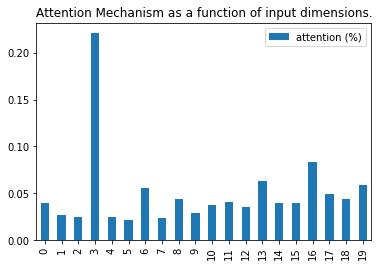

In [30]:
# plot part.
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

pd.DataFrame(attention_vector_final, columns=['attention (%)']).plot(kind='bar',
                                                                     title='Attention Mechanism as '
                                                                           'a function of input'
                                                                           ' dimensions.')
plt.show()

#### TODO: 

Repeat all the steps using attention block before LSTM. Note all the variable and code changes required to do this.

#### 2.3 - Adding Attention to your NTM

The attention in the previous toy task was a nice extra. However, in this new date translation task, you cannot make your model work properly without it.

Now it's time to add attention to the NMT model you've implemented in part (1). 

#### TODO: 

Re-implement `model_simple_nmt()` but this time with attention as `model_attention_nmt()`. Try to achieve better results by adding units, layers, and so on.

In [31]:
def model_attention_nmt(human_vocab_size, machine_vocab_size, Tx = 20):
    """
    Attention Neural Machine Translation model
    
    Arguments:
    human_vocab_size -- size of the human vocabulary for dates, it will give us the size of the embedding layer
    machine_vocab_size -- size of the machine vocabulary for dates, it will give us the size of the output vector
    
    Returns:
    model -- model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define the input of your model with a shape (Tx,)
    inputs = Input(shape=(Tx,))
    
    # Define the embedding layer. This layer should be trainable and the input_length should be set to Tx.
    input_embed = Embedding(human_vocab_size, 2*32, input_length = Tx, trainable=True)(inputs)
    
    # Encode the embeddings using a bidirectional LSTM
    enc_out = Bidirectional(LSTM(32, return_sequences=True))(input_embed)
    
    # Add attention
    attention = attention_3d_block(enc_out)
    
    # Decode the encoding using an LSTM layer
    dec_out = LSTM(32, return_sequences=True)(attention)
    
    # Apply Dense layer to every time steps
    output = TimeDistributed(Dense(machine_vocab_size, activation='softmax'))(dec_out)
    
    # Create model instance 
    model = Model(input=[inputs], output=output)
    
    ### END CODE HERE ###
    
    return model

<img src="images/enc_attention.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 5**: Attention Model</center></caption>

In [32]:
# Create model
model_att = model_attention_nmt(len(human_vocab), len(machine_vocab))

# Compile model
model_att.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/Users/jayurbain/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ti...)`


<img src="images/train_infer.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 6**: Training vs Inferencing</center></caption>

Now train the model by running the following cell:

In [33]:
model_att.fit([sources], targets, epochs=1, batch_size=12, validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 5s 6ms/step - loss: 1.8338 - acc: 0.4937 - val_loss: 1.3559 - val_acc: 0.5000


### Results

In [34]:
### START CODE HERE ### (≈1 line)
example = "3rd of March 2001"
### END CODE HERE ###
source = string_to_int(example, 20, human_vocab)
prediction = model_att.predict(np.array([source]))
prediction = np.argmax(prediction[0], axis = -1)
output = int_to_string(prediction, inv_machine_vocab)
print("source:", example)
print("output:", ''.join(output))

source: 3rd of March 2001
output: <pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


### Visualizing Attention

If you were to run the poorly trained model in this assignment, then you might get an attention map like the following:
<img src="images/poorly_trained_model.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 7**: Simple Attention Map</center></caption>

Translation of 3 May 1979 will essentially be nonsense, with a bunch of 0s and 1's without translating to a valid date string. The attention is being applied to only one character y, and hence the translation does not work.

<img src="images/date_attention.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 8**: Full Attention Map</center></caption>

A well trained model can handle a tougher translation task, such as Saturday 9 May 2018. Here you can see that the attention completely ignores Saturday, which is not helpful to our task. 9 has been translated as 09 and May has been correctly translated as 05 by giving more attention to M. The year mostly requires it to differentiate on 18 to gather 2018 as the result.

Attention map will generate the similar results for your model:

In [35]:
%matplotlib inline

def attention_map(model, input_vocabulary, inv_output_vocabulary, text):
    """
        visualization of attention map
    """
    # encode the string
    encoded = string_to_int(text, 20, input_vocabulary)

    # get the output sequence
    prediction = model.predict(np.array([encoded]))
    predicted_text = np.argmax(prediction[0], axis=-1)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)

    text_ = list(text)
    # get the lengths of the string
    input_length = len(text)
    output_length = predicted_text.index('<pad>') if '<pad>' in predicted_text else len(predicted_text)
    # get the activation map
    attention_vector = get_activations(model, [encoded], layer_name='attention_vec')[0].squeeze()
    activation_map = attention_vector[0:output_length, 0:input_length]
    
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Probability', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

#     f.show()

Run attention_map to generate the graph:

/Users/jayurbain/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/image.py:865: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


<Figure size 432x288 with 0 Axes>

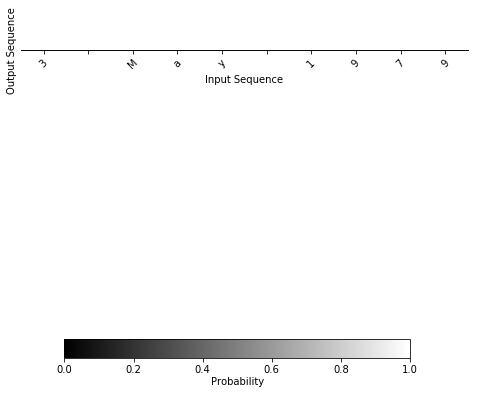

In [36]:
attention_map(model_att, human_vocab, inv_machine_vocab, EXAMPLES[0])

### 3 - BLEU score

In this final part, you are going to implement the Bilingual Evaluation Understudy (BLEU) Score to assess the effectiveness of translations as a ratio. Completely mismatched results will be scored as 0.0, and the perfect translation will be scored as 1.0. There are various formulas applied to sentence, corpus or any length translation, but it's meant to be a good proxy to compare various implementations. Our date translation examples are simple, but BLEU score is also meant to encapuslate how a human would rate the translation for language translations. 

<img src="images/BLEU.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 9**: BLEU Score</center></caption>

The BLEU could be described as the overlap of single tokens and sequences of tokens (2, 3 or 4) - this is $precision_i$. 

And also brevity penalty of $\frac{output-length}{reference - length}$ is applied in the formula.

We will split each ground truth to one character at a time and also the predicted value. BLEU score works on the 1-4 ngrams so we need to supply at least 4 ngrams in our predictions. If we had a string 2007-07-11, we can split it into tokens 2007, 07 and 11. But that makes BLEU scoring more difficult. So we are instead going to convert it to list of ['2', '0', '0', '7', '-', '0', '7', '-', '1', '1'] by making a token of every single character, including dashes.

We will be using NLTK package's implementation of bleu_score to calculate. Generate BLEU score for your simple nmt by running the following cell:

In [58]:
from nltk.translate.bleu_score import corpus_bleu
references = [[['this', 'is', 'a', 'test'], ['this', 'is' 'test']]]
candidates = [['this', 'is', 'a', 'test']]
print( type(candidates) )
score = corpus_bleu(references, candidates)
print(score)

<class 'list'>
1.0


In [59]:

# prefect match
from nltk.translate.bleu_score import sentence_bleu
reference = [['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']]
candidate = ['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']
score = sentence_bleu(reference, candidate)
print(score)

1.0


In [82]:
print(reference)
rs = []

for i in range (len(reference)):
    print(reference[i])
    rs.append( list(''.join(reference[i])) ) 
    print( list(''.join(reference[i])) )
rs


[['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']]
['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']
['t', 'h', 'e', 'q', 'u', 'i', 'c', 'k', 'b', 'r', 'o', 'w', 'n', 'f', 'o', 'x', 'j', 'u', 'm', 'p', 'e', 'd', 'o', 'v', 'e', 'r', 't', 'h', 'e', 'l', 'a', 'z', 'y', 'd', 'o', 'g']


[['t',
  'h',
  'e',
  'q',
  'u',
  'i',
  'c',
  'k',
  'b',
  'r',
  'o',
  'w',
  'n',
  'f',
  'o',
  'x',
  'j',
  'u',
  'm',
  'p',
  'e',
  'd',
  'o',
  'v',
  'e',
  'r',
  't',
  'h',
  'e',
  'l',
  'a',
  'z',
  'y',
  'd',
  'o',
  'g']]

In [72]:
# animal list
animal = ['cat', 'dog', 'rabbit']

# an element is added
animal.append('guinea pig')

#Updated Animal List
print('Updated animal list: ', animal)

Updated animal list:  ['guinea pig']


In [55]:
for i in range (len(references[0])):
    print(references[0][i])
#     l = list(references[0][i])
#     print( l )


references[0][0]

str_list=['a','b','c']
''.join(str_list)


['this', 'is', 'a', 'test']
['this', 'istest']


'abc'

In [39]:
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

EXAMPLES = ['3 May 1979', '5 Apr 09', '20th February 2016', 'Wed 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '3rd of March 2001']
GROUND_TRUTH = ['1979-05-03', '2009-04-05', '2016-02-20', '2007-07-11', '2018-05-09', '2001-03-03', '2001-03-03', '2001-03-03']

def run_example(model, input_vocabulary, inv_output_vocabulary, text):
    encoded = string_to_int(text, 20, input_vocabulary)
    prediction = model.predict(np.array([encoded]))
    prediction = np.argmax(prediction[0], axis=-1)
    return int_to_string(prediction, inv_output_vocabulary)

def run_examples(model, input_vocabulary, inv_output_vocabulary, samples=(EXAMPLES, GROUND_TRUTH)):
    predicted = []
    examples, targets = samples
    assert len(examples) == len(targets)
    
    for i, example in enumerate(examples):
        predicted.append(''.join(run_example(model, input_vocabulary, inv_output_vocabulary, example)))
        print('input:', example)
        chstr = targets[i] # .split('-')
        print('reference:', chstr)
        pdstr = predicted[i]
        ### START CODE HERE ###
        pdstr = pdstr.replace('<pad>','')
        ### END CODE HERE ###
        #pdstr = pdstr.split('-
        print('output:', pdstr)
        cc = SmoothingFunction()
        print("BLEU score: ", sentence_bleu([[ch for ch in chstr]], [pd for pd in pdstr], smoothing_function=cc.method4))
        print()
    return predicted

In [40]:
run_examples(model, human_vocab, inv_machine_vocab)

input: 3 May 1979
reference: 1979-05-03
output: 
BLEU score:  0

input: 5 Apr 09
reference: 2009-04-05
output: 
BLEU score:  0

input: 20th February 2016
reference: 2016-02-20
output: 
BLEU score:  0

input: Wed 10 Jul 2007
reference: 2007-07-11
output: 
BLEU score:  0

input: Saturday May 9 2018
reference: 2018-05-09
output: 
BLEU score:  0

input: March 3 2001
reference: 2001-03-03
output: 
BLEU score:  0

input: March 3rd 2001
reference: 2001-03-03
output: 
BLEU score:  0

input: 3rd of March 2001
reference: 2001-03-03
output: 
BLEU score:  0



['<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']

**TODO**: Generate the right BLEU scores

The translation is correct for but how come BLEU score is low? It should be 1.0 yet it's XXX Hint: Print out the actual predicted value and check the tokenized list to see what needs to be done

**TODO**: Generate your model_attention_nmt()'s BLEU score

In [ ]:
### START CODE HERE ###

### END CODE HERE ###

**TODO**: Improve your `model_attention_nmt()`'s BLEU score as close to 1.0 as you can

### BPE
BPE stands for byte pair encoding. It means that common byte pairs (bigrams of chars in our case) are replaced by a byte which never occurs in the corpus. Say, in our corpus we have never seen the "#" char, so we could use it to represent some typical bigram like "ie". But in practice all the printable chars are used, so for BPE the unprintable part of codepage is used. To actually print the text, we need to reformat it back. So you'll see in text "@@ " - these are artifacts from such renormalization.


#### Optional TODO - Experiment with Beam Search

As you have discovered, attention spreads the probability of which character to pay attention to in a given sequence. There are other strategies we can apply to improve the results of the translation. Beam search is one such heuristic that is popular. Beam search works by returning a list of output sequences that are most likely for a given input. It does this by exploring all of the possible next steps, and then chooses the most promising candidates from all possibilities. Those candidates form a 'beam' of directions, where the algorithm expands the search through each candidate's sequence of probabilities. 

The larger the beam, the better the performance of the model. Since there are more candidate sequences, this means the likelihood of finding the right answer increases. However, it requires more decoding, meaning a direct tradeoff with the quality of results versus accuracy. Seeding beam search with the most likely next words in a sequence can yield good results. The beam search would generate the resulting sequence, starting from the first word and appending, while exploring all the candidates (size of the beam) every step of the way.

We have started the beginning of beam search to generate samples with the following code:

In [ ]:
m = model_attention_nmt(len(human_vocab), len(machine_vocab))

m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(m.summary())

In [ ]:
inputs, targets = zip(*dataset)
inputs = np.array([string_to_int(i, 20, human_vocab) for i in inputs])
targets = [string_to_int(t, 20, machine_vocab) for t in targets]
targets = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), targets)))

In [ ]:
m.fit([inputs], targets, epochs=1, batch_size=64, validation_split=0.1)

In [ ]:
def keras_rnn_predict(samples, empty=human_vocab["<pad>"], rnn_model=m, maxlen=30):
    """for every sample, calculate probability for every possible label
    you need to supply your RNN model and maxlen - the length of sequences it can handle
    """
    data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty)
    return rnn_model.predict(data, verbose=0)

Here we'll try to generate some dates from our model to demostrate beam search properties:

In [ ]:
def beamsearch(predict=keras_rnn_predict, k=1, maxsample=10, 
               use_unk=False, 
               oov=human_vocab["<unk>"], 
               empty=human_vocab["<pad>"], 
               eos=human_vocab["<unk>"]):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    
    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [[empty]]
    live_scores = [0]

    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label 
        probs = predict(live_samples, empty=empty)

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k-dead_k)]
        live_scores = cand_flat[ranks_flat]

        # append the new words to their appropriate live sample
        voc_size = probs.shape[1]
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_flat]

        # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    return live_samples + dead_samples, live_scores + dead_scores

**Goldstar TODO**: 

Implement beam search and improve BLEU score.